In [ ]:
# 저는 파일을 아래와 같은 경로로 둬서 쓰고 있습니다. 이 부분은 통일하면 좋을 거 같아요!
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dacon')

In [ ]:
# 라이브러리

import pandas as pd
import numpy as np
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor


In [ ]:
# 데이터 

cus = pd.read_csv("open/cus_info.csv")
iem = pd.read_csv("open/iem_info.csv")
hist = pd.read_csv("open/stk_bnc_hist.csv")
train = pd.read_csv("open/stk_hld_train.csv")
test = pd.read_csv("open/stk_hld_test.csv")

submission = pd.read_csv("open/sample_submission.csv")

In [ ]:
hist.shape

(2573839, 7)

In [ ]:
# 앞서 언급한 것처럼 베이스라인에서는 "hist_d" column을 임의로 생성하여 모델을 학습시키도록 하겠습니다.
# 베이스라인에서는 "hold_d"값, 즉 주식 보유기간의 0.6배에 해당하는 기간을 임의로 설정하여 "hist_d"를 생성하였습니다.
# 결국 모델은 "hist_d"만큼 주식을 보유 했을때의 "hold_d"를 예측하게 될 것입니다.

train["hist_d"] = train["hold_d"]*0.6
train.hist_d = np.trunc(train["hist_d"])

In [ ]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가하겠습니다.

train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

In [ ]:
# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.

train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

In [ ]:
# 추가적으로 약간의 전처리를 통해 train data와 test data를 구성하겠습니다.

hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

train_data = train_data.drop(["act_id", "iem_cd", "byn_dt", "bse_dt"], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt"], axis = 1)

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

In [ ]:
train_data.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)

In [ ]:
train_data.shape

(681472, 18)

In [ ]:
models = []

folds = KFold(n_splits=10)
for train_idx, val_idx in folds.split(train_data):
    
    train_x = train_data.iloc[train_idx, :]
    train_y = train_label[train_idx]
    val_x = train_data.iloc[val_idx, :]
    val_y = train_label[val_idx]
    
    model = LGBMRegressor(objective= "regression",
                          max_depth= 8,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31)
    
    model.fit(train_x, train_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500)
    
    models.append(model)

Training until validation scores don't improve for 300 rounds.


KeyboardInterrupt: ignored

In [ ]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis = 0)

In [ ]:
predict

array([254.77060896, 557.71079766, 232.23969661, ..., 879.89933391,
        18.99770061,   7.46786776])

In [ ]:
submission["hold_d"] = np.round(predict)

In [ ]:
submission.to_csv("dacon_baseline.csv", index = False)

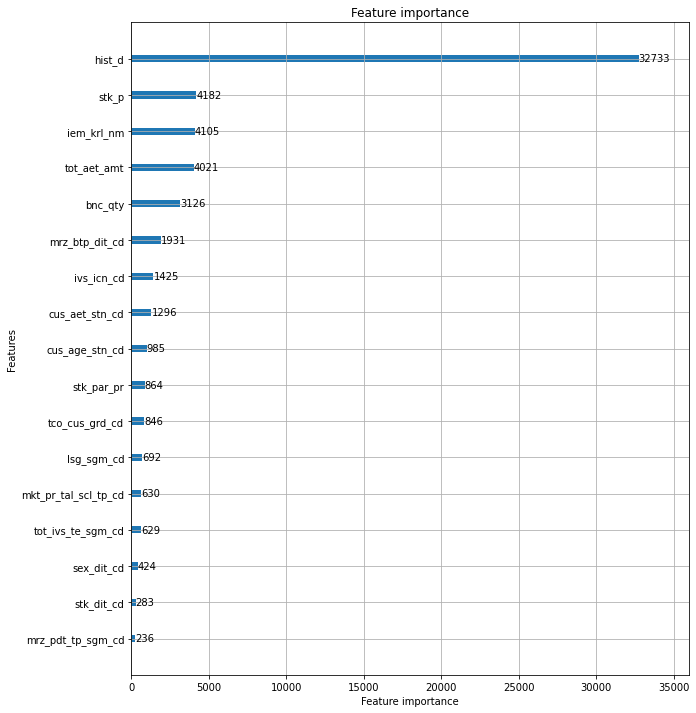

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(models[0], ax=ax)

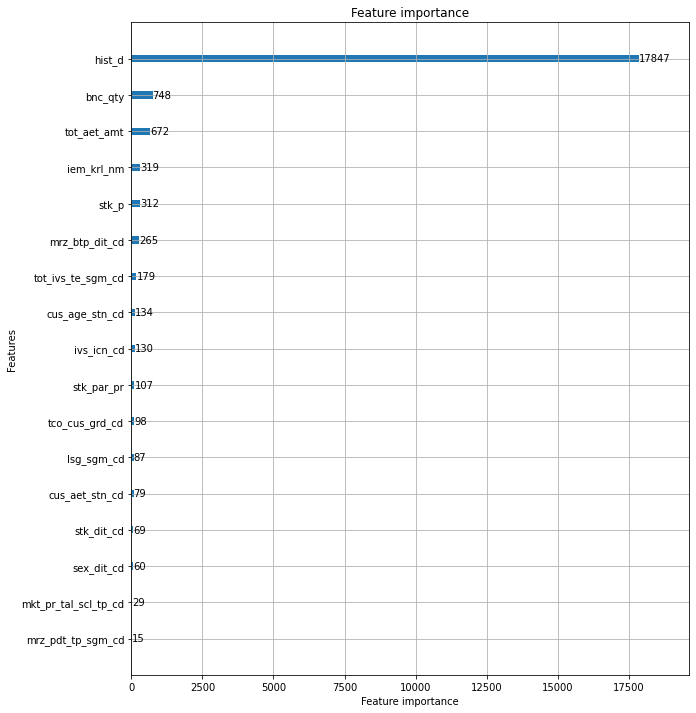

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(models[1], ax=ax)

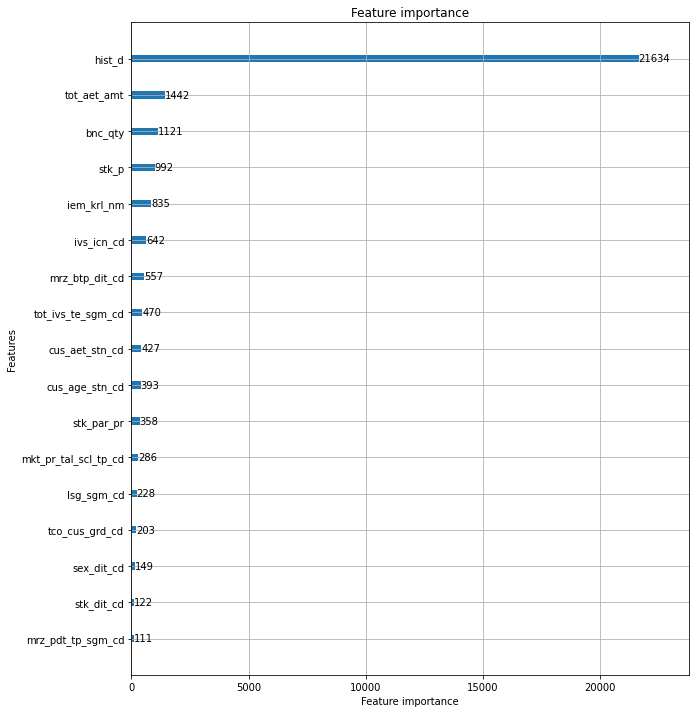

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(models[2], ax=ax)

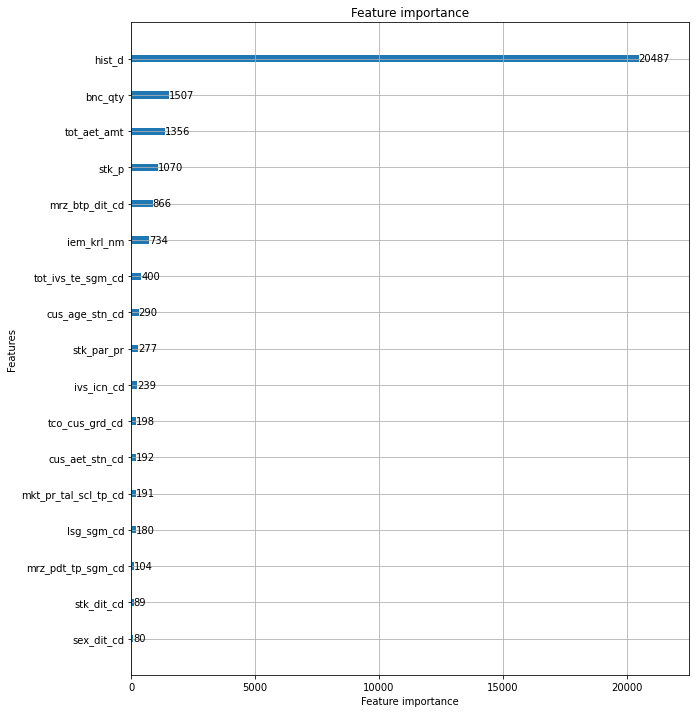

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(models[3], ax=ax)